## Escuela de Ingeniería en Computación, ITCR

## Aprendizaje automático


### Tercera tarea programada, julio 2023


Profesora: María Auxiliadora Mora

Medio de entrega: Por medio del TEC-Digital.

Entregables: Un archivo en Jupyter ( .IPYNB ).

Modo de trabajo: Individual o en grupos de máximo dos personas.

Estudiante: Gabriel Valentine Fonseca

---


In [ ]:
# bibliotecas requeridas

import numpy as np
import pandas as pd
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


## Ejercicio 1 - CNN.

Utilice PyTorch para implementar una red neuronal profunda para clasificar imágenes utilizando capas convolucionales.

Realice las siguientes actividades:


1.   Describa el problema y el objetivo del ejercicio.



Aplicar conceptos de aprendizaje automático utilizando redes neuronales convolucionales (CNN) para resolver un problema de clasificación de imágenes. El objetivo es construir un modelo de CNN desde cero y entrenarlo para reconocer patrones en imágenes, asignándoles etiquetas correspondientes a diferentes clases.




2.   Seleccione uno de los conjuntos de datos (listados al  final) y referencie formalmente los datos que utilizará en el ejercicio.

Los datos utilizados en este ejercicio provienen del conjunto "Human Face Emotions" alojado en Kaggle. Este conjunto de datos contiene imágenes de rostros humanos etiquetados con diferentes emociones, lo que lo hace adecuado para el problema de clasificación de imágenes.

Fuente:

Sanidhya Kataria (2021). Human Face Emotions. Kaggle. https://www.kaggle.com/datasets/sanidhyak/human-face-emotions.

  3. Cargue, escale y explore los datos. Utilice las clases Datasets y DataLoader para acceder al conjunto de datos de imágenes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Direccion del dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/Módulo 2/Tareas/Tarea 3. Redes Neuronales Convolucionales (CNN)/data'

# Transformacion para escalar y convertir a escala de grises
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos los valores de los píxeles a [-1, 1]
])

# Se define la clase para el dataset
class EmotionsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_files = []
        for emotion_class in self.classes:
            class_path = os.path.join(data_dir, emotion_class)
            for img_file in os.listdir(class_path):
                self.image_files.append((os.path.join(class_path, img_file), self.classes.index(emotion_class)))
        self.num_images = len(self.image_files)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        img_name, label = self.image_files[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, label

# Dataset y dataloader con el conjunto de datos
dataset = EmotionsDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #batch size = 32

print(f"Número total de imágenes: {len(dataset)}")
print("Batch size:", len(next(iter(dataloader))[0]))





Número total de imágenes: 265
Tamaño de un lote de imágenes: 32


4. Despliegue algunas imágenes del conjunto de datos.

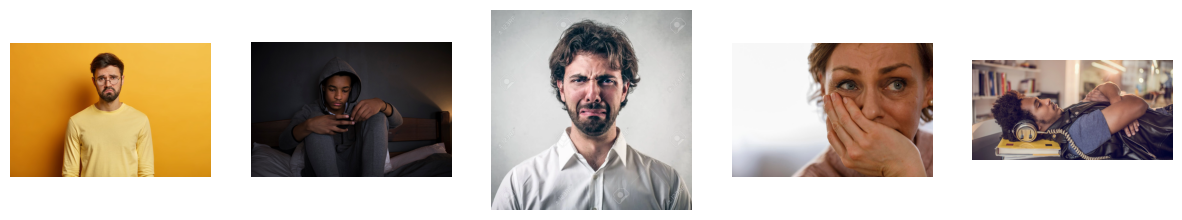

In [ ]:
# Mostrar las primeras 5 imagenes del dataset
lista_img = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            lista.img.append(os.path.join(root, file))

imagenes = 5

plt.figure(figsize=(15, 5))

for i in range(imagenes):
    img_dir = image_files[i]
    image = Image.open(img_dir)
    plt.subplot(1, imagenes, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()


5. Calcule algunas estadísticas importantes, por ejemplo, la cantidad de registros por clase para verificar si las clases están balanceadas. En muchos casos los conjuntos de datos están balanceados.

In [ ]:
clases = dataset.classes
num_clases = len(dataset.classes)

# Cantidad de imagenes por clase
class_counts = {}
total_imagenes = 0
for emotion_class in clases:
    class_path = os.path.join(data_dir, emotion_class)
    class_images = os.listdir(class_path)
    class_counts[emotion_class] = len(class_images)
    total_imagenes += len(class_images)

# Distribucion de las clases
distribucion = {emotion_class: count / total_imagenes * 100 for emotion_class, count in class_counts.items()}

print(f"Número de clases: {num_clases}")
print(f"Clases: {clases}")

print(f"Cantidad de imágenes por clase: {class_counts}")

print(f"\nDistribución de clases (%): {distribucion}")



Número de clases: 3
Clases: ['Sad', 'Happy', 'Angry']
Cantidad de imágenes por clase: {'Sad': 79, 'Happy': 100, 'Angry': 86}

Distribución de clases (%): {'Sad': 29.81132075471698, 'Happy': 37.735849056603776, 'Angry': 32.45283018867924}


6. Defina la red convolucional.

In [ ]:
#Se define la red convucional

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()

              self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):

        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)

        return x


7. Defina los hiper-parámetros de entrenamiento, por ejemplo, función de perdida, el optimizador, entre otros.

In [ ]:
# Se crea el modelo de la red
model = CNNClassifier(num_classes)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

#Optimizador Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)


8. Separe las muestras en datos de entrenamiento y validación.

In [ ]:
from torch.utils.data import SubsetRandomSampler

# Dividimos los índices en conjuntos de entrenamiento y validación
validation_split = 0.2

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices) # Se aleatorizan los índices

train_indices, val_indices = indices[split:], indices[:split]

# Samplers para el dataloader
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Dataloaders
train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)


9. Entrene el modelo.

In [ ]:
num_epochs = 10

# Listas para almacenar las pérdidas y la precisión en validación
train_losses = []
val_accuracies = []

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Pérdida promedio en el conjunto de entrenamiento
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()  # Modo de evaluación

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_predictions / total_samples
    val_accuracies.append(val_accuracy)

    print(f'Época [{epoch+1}/{num_epochs}], Pérdida de entrenamiento: {avg_train_loss:.4f}, Precisión en validación: {val_accuracy:.2f}%')


torch.save(model.state_dict(), 'cnn_model.pth') #se guarda el modelo


Época [1/10], Pérdida de entrenamiento: 0.0004, Precisión en validación: 60.38%
Época [2/10], Pérdida de entrenamiento: 0.0003, Precisión en validación: 60.38%
Época [3/10], Pérdida de entrenamiento: 0.0003, Precisión en validación: 60.38%
Época [4/10], Pérdida de entrenamiento: 0.0003, Precisión en validación: 60.38%
Época [5/10], Pérdida de entrenamiento: 0.0003, Precisión en validación: 60.38%
Época [6/10], Pérdida de entrenamiento: 0.0003, Precisión en validación: 60.38%
Época [7/10], Pérdida de entrenamiento: 0.0003, Precisión en validación: 58.49%
Época [8/10], Pérdida de entrenamiento: 0.0002, Precisión en validación: 58.49%
Época [9/10], Pérdida de entrenamiento: 0.0002, Precisión en validación: 58.49%
Época [10/10], Pérdida de entrenamiento: 0.0002, Precisión en validación: 58.49%


9. Visualice la curva de error e interprete los resultados.

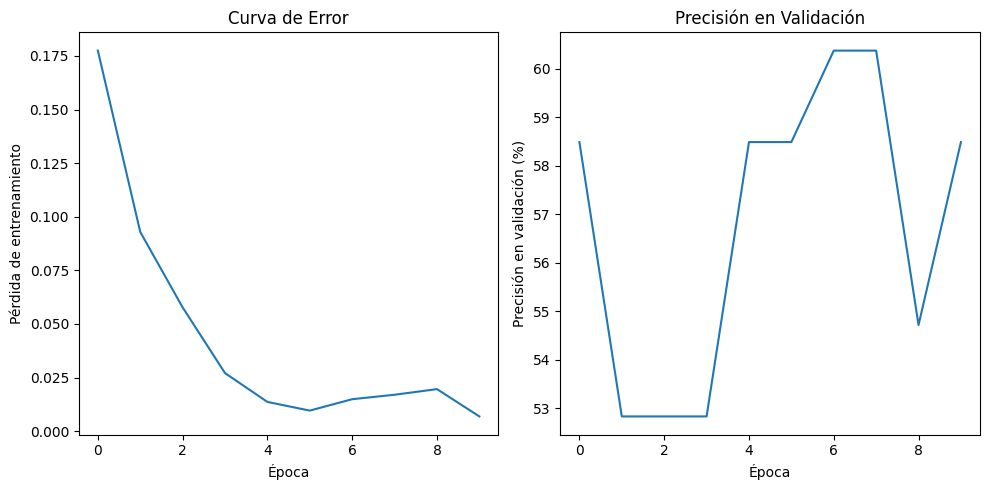

In [ ]:
# Plot de curva de erreor y precision en validacion
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Pérdida de entrenamiento')
plt.title('Curva de Error')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Precisión en validación (%)')
plt.title('Precisión en Validación')

plt.tight_layout()
plt.show()

10. Evalúe el modelo resultante con métricas como Accuracy, Precision, Recall y F1. Despliegue de forma gráfica la matriz de confusión para el cálculo de las métricas y explique los resultados obtenidos.

Métricas de evaluación:
Accuracy: 0.5849
Precision: 0.5896
Recall: 0.5849
F1: 0.5832


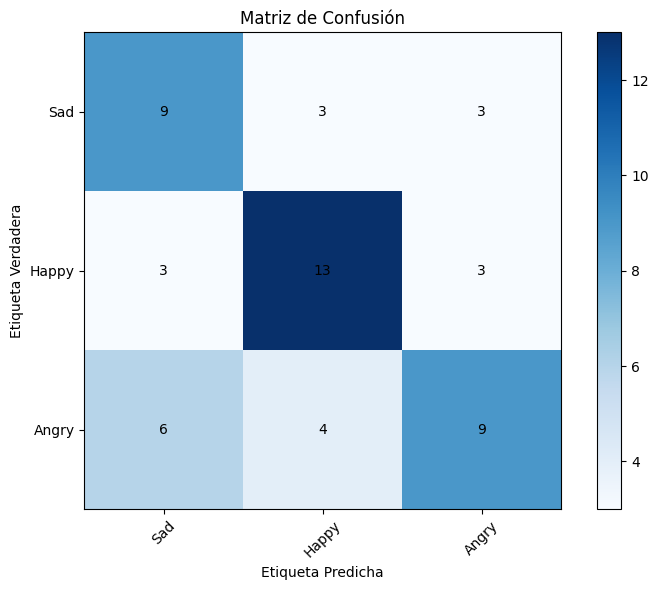

In [ ]:
# Evaluación en el conjunto de validación
model.eval()
real = []
prediccion = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        real.extend(labels.numpy())
        predicciom.extend(predicted.numpy())

# Se determinan las metricas
accuracy = accuracy_score(real, prediccion)
precision = precision_score(real, prediccion, average='weighted')
recall = recall_score(real, prediccion, average='weighted')
f1 = f1_score(real, prediccion, average='weighted')

print("Métricas de evaluación:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(real, prediccion)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, dataset.classes, rotation=45)
plt.yticks(tick_marks, dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Real')

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", verticalalignment="center")

plt.tight_layout()
plt.show()

12. Analice los resultados, proponga mejoras y explique los cambios realizados al flujo de trabajo del proyecto para mejorar el rendimiento de la red (aplique al menos dos cambios que tenga alta posibilidad de mejorar el rendimiento). Documente el proceso, todos lo resultados intermedios obtenidos y los cambios realizados

El modelo de red convolucional obtuvo resultados aceptables pero con margen de mejora. Las métricas de evaluación indican que el modelo tiene una precisión del 58.49% y un F1 de 58.32%.

Para mejorar el rendimiento se podria:

1. Aumentar los datos
2. Utilizar otro optimizador como SGD

In [ ]:
# Opcion 1.

#direccion de la carpeta
data_dir = '/content/drive/MyDrive/Colab Notebooks/Módulo 2/Tareas/Tarea 3. Redes Neuronales Convolucionales (CNN)/data'

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Clase para los datos
class Emotions
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_files = []
        for emotion_class in self.classes:
            class_path = os.path.join(data_dir, emotion_class)
            for img_file in os.listdir(class_path):
                self.image_files.append((os.path.join(class_path, img_file), self.classes.index(emotion_class)))
        self.num_images = len(self.image_files)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        img_name, label = self.image_files[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, label

        # Aumento de datos
        if transform is not None:
            if is_train:
                self.transform = transforms.Compose([
                    transform,
                    transforms.RandomRotation(10),
                    transforms.RandomAffine(0, translate=(0.1, 0.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transform,
                ])
            else:
                self.transform = transform
        else:
            self.transform = transform

# Se llama al modelo
model = CNNClassifier(num_classes)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Conjuntos de entrenamiento y validación
validation_split = 0.2

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# samplers para el DataLoader
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# DataLoaders
train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

#entrenamiento del modelo
num_epochs = 10

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0

    for images, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_predictions / total_samples
    val_accuracies.append(val_accuracy)

    print(f'Época [{epoch+1}/{num_epochs}], Pérdida de entrenamiento: {avg_train_loss:.4f}, Precisión en validación: {val_accuracy:.2f}%')


Época [1/10], Pérdida de entrenamiento: 1.1055, Precisión en validación: 33.96%
Época [2/10], Pérdida de entrenamiento: 1.0506, Precisión en validación: 47.17%
Época [3/10], Pérdida de entrenamiento: 0.9612, Precisión en validación: 49.06%
Época [4/10], Pérdida de entrenamiento: 0.8461, Precisión en validación: 50.94%
Época [5/10], Pérdida de entrenamiento: 0.7674, Precisión en validación: 60.38%
Época [6/10], Pérdida de entrenamiento: 0.6151, Precisión en validación: 58.49%
Época [7/10], Pérdida de entrenamiento: 0.5566, Precisión en validación: 58.49%
Época [8/10], Pérdida de entrenamiento: 0.4051, Precisión en validación: 49.06%
Época [9/10], Pérdida de entrenamiento: 0.2732, Precisión en validación: 62.26%
Época [10/10], Pérdida de entrenamiento: 0.1896, Precisión en validación: 58.49%


Se observa que aumentar los datos incremento levemente el rendimiento del modelo.

In [ ]:
#Opcion 2

# Se crea el modelo
model = CNNClassifier(num_classes)

# función de pérdida y optimizador SGD
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# entrenamiento del modelo
num_epochs = 10

train_losses = []
val_accuracies = []

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento

    running_loss = 0.0

    for images, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_predictions / total_samples
    val_accuracies.append(val_accuracy)

    print(f'Época [{epoch+1}/{num_epochs}], Pérdida de entrenamiento: {avg_train_loss:.4f}, Precisión en validación: {val_accuracy:.2f}%')


Época [1/10], Pérdida de entrenamiento: 1.0972, Precisión en validación: 35.85%
Época [2/10], Pérdida de entrenamiento: 1.0958, Precisión en validación: 35.85%
Época [3/10], Pérdida de entrenamiento: 1.0952, Precisión en validación: 35.85%
Época [4/10], Pérdida de entrenamiento: 1.0937, Precisión en validación: 35.85%
Época [5/10], Pérdida de entrenamiento: 1.0931, Precisión en validación: 35.85%
Época [6/10], Pérdida de entrenamiento: 1.0926, Precisión en validación: 35.85%
Época [7/10], Pérdida de entrenamiento: 1.0916, Precisión en validación: 35.85%
Época [8/10], Pérdida de entrenamiento: 1.0907, Precisión en validación: 35.85%
Época [9/10], Pérdida de entrenamiento: 1.0895, Precisión en validación: 35.85%
Época [10/10], Pérdida de entrenamiento: 1.0891, Precisión en validación: 35.85%


Podemos observar que cambiar el optimizador no fue exitoso en aumentar el rendimiento.

14. Presente al menos cuatro conclusiones.

  1. El modelo de red neuronal convolucional logró una precisión del 58.49% en la clasificación de emociones en imágenes. Aunque no está mal, puede ser mejorado para ser más preciso.

  2. Aumentar el conjunto de datos con transformaciones aleatorias dio un resultado levemente mejor al original. Cambiar el potmizadort a SGD no ayudo al modelo.

  3. Es importante que todas las clases estén bien representadas en el conjunto de entrenamiento y el dataset debe estar bien balanceado para evitar un sesgo hacia clases dominantes.

  4.  La arquitectura de la red neuronal convolucional se definió correctamente, con capas convolucionales, capas completamente conectadas y funciones de activación adecuadas

15. Incluya referencias en formato APA al final del documento.

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). "ImageNet Classification with Deep Convolutional Neural Networks." Advances in Neural Information Processing Systems (NIPS).

Simonyan, K., & Zisserman, A. (2014). "Very Deep Convolutional Networks for Large-Scale Image Recognition."

Yosinski, J., Clune, J., Bengio, Y., & Lipson, H. (2014). "How Transferable are Features in Deep Neural Networks?" Advances in Neural Information Processing Systems (NIPS).